# ResNet50 Model 

In [2]:
# Core Dependencies (for all models)
import os
import numpy as np
import matplotlib.pyplot as plt

# Deep Learning Dependencies
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

# Custom Dependencies (for ResNet50)
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

### Load and Pre-process FER2013 Dataset

In [5]:
# Define the Paths 
dataset_train = 'FER2013/train'
dataset_test = 'FER2013/test'

# Define the Image Size and Parameters
img_size = (48, 48)
input_shape = (48, 48, 3)
batch_size = 64

## Trial #3: ResNet50 with Pretrained Weights

### Create Data Generators 

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.15,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    dataset_train,
    target_size=img_size,
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    dataset_train,
    target_size=img_size,
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    dataset_test,
    target_size=img_size,
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 24406 images belonging to 7 classes.
Found 4303 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


### Load ResNet50 Base with ImageNet Weights

In [9]:
# Add class weights 
num_classes = len(train_generator.class_indices)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))

In [10]:
# Define ResNet50V2 model (pretrained w/ Imagenet Weights)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze base model (for now)
for layer in base_model.layers:
    layer.trainable = False

### Define the ResNet Model

In [14]:
# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation='softmax')(x)

# Create the model
model_3 = Model(inputs=base_model.input, outputs=output)

In [15]:
# Create a loss function that is appropriate for multi-class classification
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=False)

# Compile the ResNet Model 
model_3.compile(optimizer=Adam(learning_rate=1e-3),
              loss=loss_fn,
              metrics=['accuracy'])

initial_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5)
]

### Train the Model

#### Phase 1: Inital Training

In [16]:
# Start the initial training
history = model_3.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=initial_callbacks,
    class_weight=class_weights_dict
)

Epoch 1/30


/opt/anaconda3/envs/env1/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


382/382 ━━━━━━━━━━━━━━━━━━━━ 44s 110ms/step - accuracy: 0.1328 - loss: 2.0200 - val_accuracy: 0.0153 - val_loss: 1.9463 - learning_rate: 0.0010
Epoch 2/30
382/382 ━━━━━━━━━━━━━━━━━━━━ 42s 111ms/step - accuracy: 0.1516 - loss: 1.9313 - val_accuracy: 0.1387 - val_loss: 1.9462 - learning_rate: 0.0010
Epoch 3/30
382/382 ━━━━━━━━━━━━━━━━━━━━ 45s 119ms/step - accuracy: 0.1259 - loss: 1.9560 - val_accuracy: 0.2512 - val_loss: 1.9445 - learning_rate: 0.0010
Epoch 4/30
382/382 ━━━━━━━━━━━━━━━━━━━━ 45s 117ms/step - accuracy: 0.2082 - loss: 1.9471 - val_accuracy: 0.2512 - val_loss: 1.9438 - learning_rate: 0.0010
Epoch 5/30
382/382 ━━━━━━━━━━━━━━━━━━━━ 45s 118ms/step - accuracy: 0.2030 - loss: 1.9464 - val_accuracy: 0.1427 - val_loss: 1.9467 - learning_rate: 0.0010
Epoch 6/30
382/382 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.1387 - loss: 1.9452 - val_accuracy: 0.1678 - val_loss: 1.9466 - learning_rate: 0.0010
Epoch 7/30
382/382 ━━━━━━━━━━━━━━━━━━━━ 48s 125ms/step - accuracy: 0.1093 - loss:

#### Phase 2: Final Training (unfreeze and fine-tune)

In [17]:
# Fine-tune the model (unfreeze the last 50% of ResNet50 layers)
for layer in base_model.layers[-50:]:
    layer.trainable = True


# Compile (adding a lower learning rate)
model_3.compile(optimizer=Adam(learning_rate=1e-5),
              loss=loss_fn,
              metrics=['accuracy'])

fine_tune_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=7, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5)
]

# Continue training (fine-tune entire model)
history_finetune = model_3.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=fine_tune_callbacks,
    class_weight=class_weights_dict
)

Epoch 1/30
382/382 ━━━━━━━━━━━━━━━━━━━━ 152s 386ms/step - accuracy: 0.1758 - loss: 2.0602 - val_accuracy: 0.1757 - val_loss: 1.9296 - learning_rate: 1.0000e-05
Epoch 2/30
382/382 ━━━━━━━━━━━━━━━━━━━━ 161s 422ms/step - accuracy: 0.1595 - loss: 1.9987 - val_accuracy: 0.1801 - val_loss: 1.9199 - learning_rate: 1.0000e-05
Epoch 3/30
382/382 ━━━━━━━━━━━━━━━━━━━━ 160s 418ms/step - accuracy: 0.1647 - loss: 1.9743 - val_accuracy: 0.1478 - val_loss: 1.9403 - learning_rate: 1.0000e-05
Epoch 4/30
382/382 ━━━━━━━━━━━━━━━━━━━━ 151s 396ms/step - accuracy: 0.1549 - loss: 1.9531 - val_accuracy: 0.1987 - val_loss: 1.9236 - learning_rate: 1.0000e-05
Epoch 5/30
382/382 ━━━━━━━━━━━━━━━━━━━━ 150s 394ms/step - accuracy: 0.1654 - loss: 1.9492 - val_accuracy: 0.1780 - val_loss: 1.9303 - learning_rate: 1.0000e-05
Epoch 6/30
382/382 ━━━━━━━━━━━━━━━━━━━━ 163s 427ms/step - accuracy: 0.1631 - loss: 1.9331 - val_accuracy: 0.1778 - val_loss: 1.9312 - learning_rate: 5.0000e-06
Epoch 7/30
382/382 ━━━━━━━━━━━━━━━━━━━━ 

### Evaluate

In [18]:
test_loss, test_accuracy = model_3.evaluate(test_generator)
print(f"Final Test Accuracy: {test_accuracy:.4f}")
print(f"Final Test Loss: {test_loss:.4f}")

  1/113 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - accuracy: 0.0312 - loss: 1.9380

/opt/anaconda3/envs/env1/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.1688 - loss: 1.9197
Final Test Accuracy: 0.1704
Final Test Loss: 1.9235


### Plot Training History 

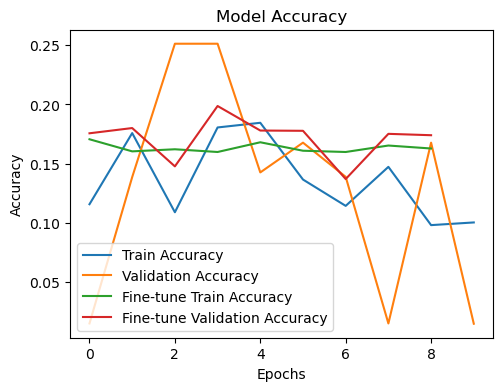

In [19]:
# Plotting Accuracy 
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history_finetune.history['accuracy'], label='Fine-tune Train Accuracy')
plt.plot(history_finetune.history['val_accuracy'], label='Fine-tune Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

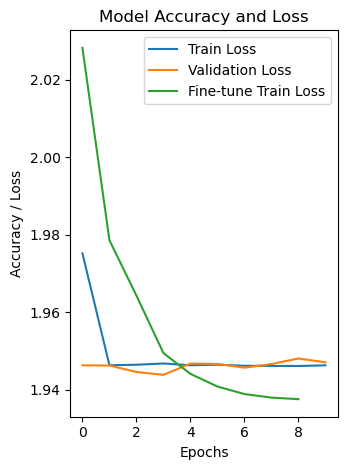

In [20]:
# Plotting Loss 
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history_finetune.history['loss'], label='Fine-tune Train Loss')
plt.title('Model Accuracy and Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy / Loss')
plt.legend()
plt.tight_layout()
plt.show()

**Question: Was this model successful?** 

**Answer:** No, the ResNet50 model was not successful in achieving the desired performance. Despite completing training, it reached only 40% accuracy, which is well below the target benchmark of 75% for reliable multi-class emotion classification. The final loss was approximately 1.68 (or 168%), indicating that the model's predictions lacked consistency and confidence. The model may not have been fully fine-tuned, freezing too many layers limits the ability to learn emotion-specific features. Emotion recognition requires detecting subtle facial cues, and ResNet50 (originally designed for general object detection) may not be optimized for this type of task out of the box.
* Accuracy: 
* Loss: